In [ ]:
import os 
os.environ['KAGGLE_CONFIG_DIR']='/content'
!chmod 600 /content/kaggle.json
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!unzip \*.zip && rm *.zip

In [ ]:
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten, Activation, LayerNormalization, Softmax
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score
import seaborn as sns
from keras.callbacks import ModelCheckpoint
from keras import models

In [ ]:
def prepare_input(filename):
  images = glob.glob(filename)
  imgs = np.array([cv2.resize(cv2.imread(file,0),(227,227)) for file in images])
  imgs=imgs.reshape(-1,227,227,1)
  #imgs=imgs[:,:,:,:1]
  return imgs

In [ ]:
covid_imgs = prepare_input('/content/COVID-19_Radiography_Dataset/COVID/*.png')
normal_imgs = prepare_input('/content/COVID-19_Radiography_Dataset/Normal/*.png')
pneum_imgs = prepare_input('/content/COVID-19_Radiography_Dataset/Viral Pneumonia/*.png')
print(covid_imgs.shape)
print(normal_imgs.shape)
print(pneum_imgs.shape)

(3616, 227, 227, 1)
(10192, 227, 227, 1)
(1345, 227, 227, 1)


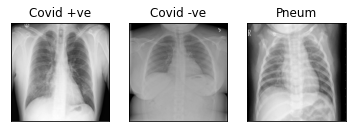

In [ ]:
plt.subplot(1,3,1),
plt.imshow(covid_imgs[0].reshape(227,227),cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Covid +ve')
plt.subplot(1,3,2)
plt.imshow(normal_imgs[0].reshape(227,227),cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Covid -ve')
plt.subplot(1,3,3)
plt.imshow(pneum_imgs[0].reshape(227,227),cmap='gray')
plt.xticks([]), plt.yticks([])
plt.title('Pneum')
plt.show()

In [ ]:
full_data=np.vstack((covid_imgs,normal_imgs,pneum_imgs))
print(full_data.shape)

(15153, 227, 227, 1)


In [ ]:
y_data=np.array([0.0]*len(covid_imgs)+[1.0]*len(normal_imgs)+[2.0]*len(pneum_imgs))
print(y_data.shape)

(15153,)


In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=36)
for train_index, test_index in sss.split(full_data, y_data):
 X_train = full_data[train_index]
 y_train= y_data[train_index]
 X_test = full_data[test_index]
 y_test= y_data[test_index]

In [ ]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12122, 227, 227, 1)
(12122, 1)
(3031, 227, 227, 1)
(3031, 1)


In [ ]:
print(np.count_nonzero(y_train==2)/len(y_train))
print(np.count_nonzero(y_test==2)/len(y_test))
print(np.count_nonzero(y_train==1)/len(y_train))
print(np.count_nonzero(y_test==1)/len(y_test))

0.08876423032502888
0.08874958759485319
0.6725787823791454
0.6727152754866381


In [ ]:
model = Sequential()
model.add(Conv2D(96, kernel_size=(11,11),use_bias=True,strides=(4,4), padding='valid',input_shape=X_train[0].shape,activation='relu' ))
model.add(LayerNormalization())
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'))
model.add(Conv2D(256, kernel_size=(5,5),strides=(1,1),use_bias=True,groups=2, padding='same',activation='relu' ))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'))
model.add(Conv2D(256, kernel_size=(5,5),strides=(1,1),use_bias=True,groups=2, padding='same',activation='relu' ))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2),padding='valid'))
model.add(Flatten())
model.add(Dense(3,activation='softmax'))

In [ ]:
opt = Adam(learning_rate=0.00005)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 55, 55, 96)        11712     
_________________________________________________________________
layer_normalization_3 (Layer (None, 55, 55, 96)        192       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 27, 27, 256)       307456    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 256)       819456    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 6, 6, 256)        

In [ ]:
epochs = 20
checkpoint = ModelCheckpoint('best_model_multi.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(
  X_train,y_train,
  validation_data=(X_test,y_test),
  batch_size=32,
  epochs=epochs,
  callbacks = [checkpoint],
  verbose = 0
)


Epoch 00001: val_accuracy improved from -inf to 0.88783, saving model to best_model_multi.h5

Epoch 00002: val_accuracy did not improve from 0.88783

Epoch 00003: val_accuracy improved from 0.88783 to 0.92841, saving model to best_model_multi.h5

Epoch 00004: val_accuracy improved from 0.92841 to 0.94886, saving model to best_model_multi.h5

Epoch 00005: val_accuracy improved from 0.94886 to 0.95645, saving model to best_model_multi.h5

Epoch 00006: val_accuracy did not improve from 0.95645

Epoch 00007: val_accuracy improved from 0.95645 to 0.95909, saving model to best_model_multi.h5

Epoch 00008: val_accuracy improved from 0.95909 to 0.96602, saving model to best_model_multi.h5

Epoch 00009: val_accuracy did not improve from 0.96602

Epoch 00010: val_accuracy improved from 0.96602 to 0.96635, saving model to best_model_multi.h5

Epoch 00011: val_accuracy did not improve from 0.96635

Epoch 00012: val_accuracy improved from 0.96635 to 0.96800, saving model to best_model_multi.h5

Ep

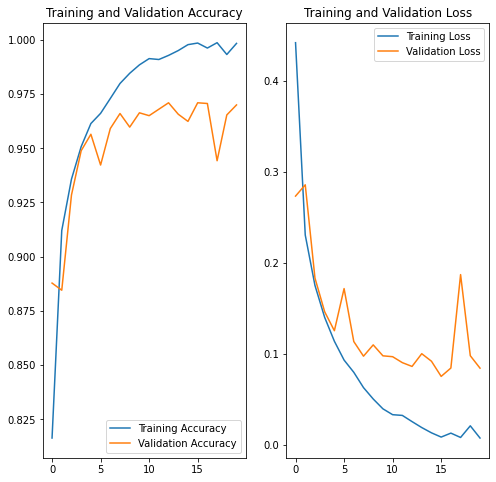

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# using the model at the best epoch
model.load_weights('best_model_multi.h5')

In [ ]:
y_pred_value=model.predict(X_test)
y_pred = np.argmax(y_pred_value,axis=-1)
print(y_pred)

[1 1 0 ... 1 0 1]


In [ ]:
print(accuracy_score(y_test,y_pred))

0.9709666776641372


In [ ]:
confusion_mat = confusion_matrix(y_test,y_pred)

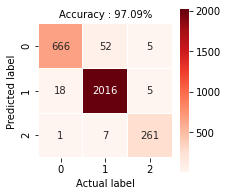

In [ ]:
plt.figure(figsize=(3,3))
sns.heatmap(confusion_mat, annot=True, fmt=".0f", linewidths=.2, square = True, cmap = 'Reds');
plt.ylabel('Predicted label');
plt.xlabel('Actual label');
all_sample_title = 'Accuracy : {}%'.format(int(accuracy_score(y_test,y_pred)*10000)/100)
plt.title(all_sample_title, size = 10);

In [ ]:
redef_model = models.Model(inputs=model.inputs, outputs=model.layers[1].output)

In [ ]:
feature_maps = redef_model.predict(full_data[0].reshape(-1,227,227,1))

In [ ]:
feature_maps.shape

(1, 55, 55, 96)

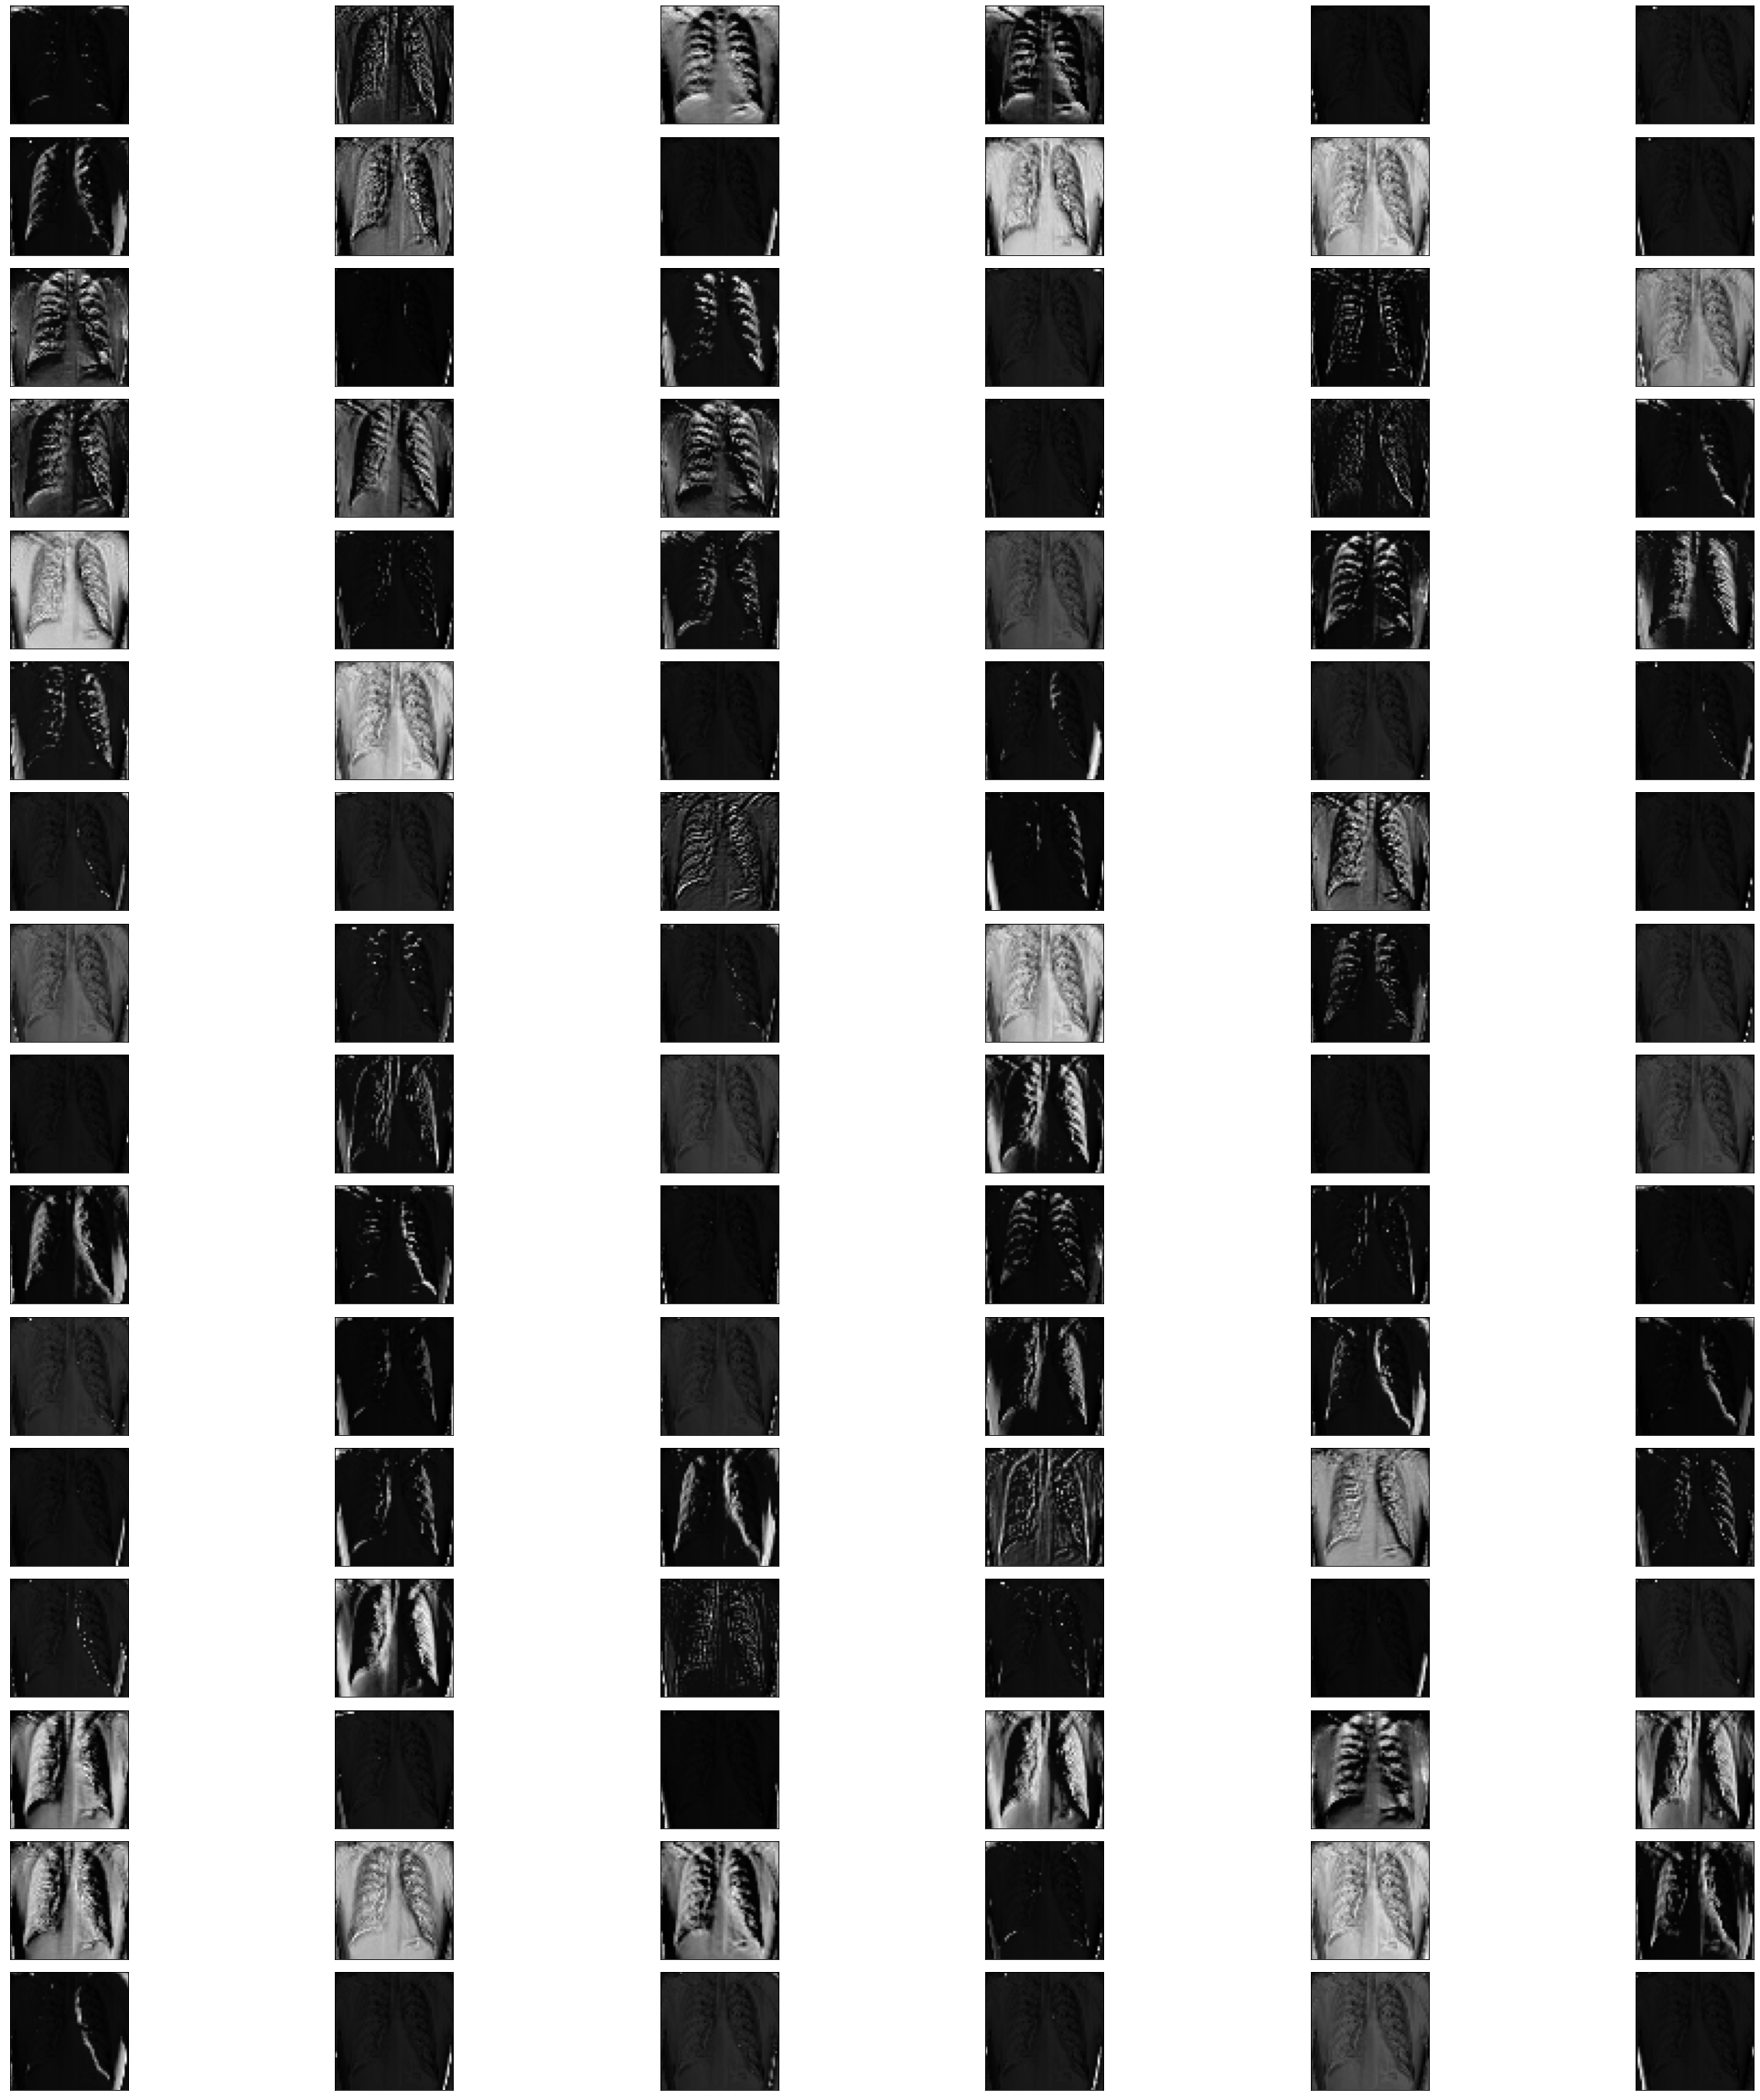

In [ ]:
columns = 6
rows = 16
num = 1
fig = plt.figure(figsize = (32,32))
for col in range(columns):
  for row in range(rows):
    fig.add_subplot(rows,columns,num)
    plt.xticks([]), plt.yticks([])
    plt.imshow(feature_maps[0, :, :, num-1], cmap='gray')
    num+=1
plt.tight_layout()
plt.show()

In [72]:
acc = accuracy_score(y_test,y_pred)
precision = precision_score(y_test,y_pred,average='macro')
recall = recall_score(y_test,y_pred,average='macro')
print("Accuracy : {}%".format(int(acc*10000)/100))
print("Precision : {}".format(precision))
print("Recall : {}".format(recall))

Accuracy : 97.09%
Precision : 0.9689762232597262
Recall : 0.960047336513183
